In [2]:
import pyreadr
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [3]:
# Only Training data is used

df_FaultFree = pyreadr.read_r(r'F:\TEP_Data\The TEP Dataset\TEP_FaultFree_Training.RData')['fault_free_training']
df_Faulty = pyreadr.read_r(r'F:\TEP_Data\The TEP Dataset\TEP_Faulty_Training.RData')['faulty_training']

In [4]:
DF = pd.concat([df_FaultFree,df_Faulty]) # Join both fault free and faulty dataset
DF.head()

faultNumber  simulationRun  sample  xmeas_1  xmeas_2  xmeas_3  xmeas_4  \
0          0.0            1.0       1  0.25038   3674.0   4529.0   9.2320   
1          0.0            1.0       2  0.25109   3659.4   4556.6   9.4264   
2          0.0            1.0       3  0.25038   3660.3   4477.8   9.4426   
3          0.0            1.0       4  0.24977   3661.3   4512.1   9.4776   
4          0.0            1.0       5  0.29405   3679.0   4497.0   9.3381   

   xmeas_5  xmeas_6  xmeas_7  ...   xmv_2   xmv_3   xmv_4   xmv_5   xmv_6  \
0   26.889   42.402   2704.3  ...  53.744  24.657  62.544  22.137  39.935   
1   26.721   42.576   2705.0  ...  53.414  24.588  59.259  22.084  40.176   
2   26.875   42.070   2706.2  ...  54.357  24.666  61.275  22.380  40.244   
3   26.758   42.063   2707.2  ...  53.946  24.725  59.856  22.277  40.257   
4   26.889   42.650   2705.1  ...  53.658  28.797  60.717  21.947  39.144   

    xmv_7   xmv_8   xmv_9  xmv_10  xmv_11  
0  42.323  47.757  47.510  41.258  18.447  
1  38.554  43.692  47.427  41.359  17.194  
2  38.990  46.699  47.468  41.199  20.530  
3  38.072  47.541  47.658  41.643  18.089  
4  41.955  47.645  47.346  41.507  18.461  

[5 rows x 55 columns]

# Select a subset

In [58]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
sc = StandardScaler()

sc.fit(DF[DF['faultNumber']==0].iloc[:,3:])



StandardScaler()

In [59]:
# Select a subset of the data from simulation runs 1 to 10, and filter out fault numbers 9 and 15
reduced_data = DF.loc[(DF['simulationRun'] >= 0) & (DF['simulationRun'] <= 10)]
reduced_data = reduced_data[reduced_data['faultNumber'] != 9]
reduced_data = reduced_data[reduced_data['faultNumber'] != 15]

# Apply scaling transformation to selected features of the filtered dataset
X = sc.transform(reduced_data[reduced_data['sample'] > 20].iloc[:, 3:])

# Extract the fault numbers that occur after the 20th sample
Y = reduced_data[reduced_data['sample'] > 20]['faultNumber'].values

# One Hot Encoding the training data

In [60]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(sparse=False)
enc.fit(Y.reshape(-1, 1))

Y_enc = enc.transform(Y.reshape(-1, 1))

# Train test split

In [61]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y_enc, test_size=0.2, random_state=42)

# Train the Neural Network algorithms

In [62]:
from keras.layers import Input, Dense
from keras.models import Model

# Define input layer
inputs = Input(shape=(x_train.shape[1],))

# Define hidden layer with 16 nodes and ReLU activation function
hidden_layer = Dense(100, activation='relu')(inputs)
hidden_layer = Dense(100, activation='relu')(hidden_layer)
# Define output layer with sigmoid activation function for binary classification
outputs = Dense(y_train.shape[1], activation='softmax')(hidden_layer)

# Define the model
model = Model(inputs=inputs, outputs=outputs)

# Compile the model with binary cross-entropy loss function and Adam optimizer
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print the summary of the model
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 52)]              0         
                                                                 
 dense_3 (Dense)             (None, 100)               5300      
                                                                 
 dense_4 (Dense)             (None, 100)               10100     
                                                                 
 dense_5 (Dense)             (None, 19)                1919      
                                                                 
Total params: 17,319
Trainable params: 17,319
Non-trainable params: 0
_________________________________________________________________


Epoch 1/200
570/570 [==============================] - 4s 5ms/step - loss: 1.1236 - accuracy: 0.6489 - val_loss: 0.7515 - val_accuracy: 0.7490
Epoch 2/200
570/570 [==============================] - 2s 3ms/step - loss: 0.6365 - accuracy: 0.7876 - val_loss: 0.5948 - val_accuracy: 0.8072
Epoch 3/200
570/570 [==============================] - 2s 3ms/step - loss: 0.4996 - accuracy: 0.8361 - val_loss: 0.4743 - val_accuracy: 0.8436
Epoch 4/200
570/570 [==============================] - 2s 3ms/step - loss: 0.4122 - accuracy: 0.8628 - val_loss: 0.4131 - val_accuracy: 0.8623
Epoch 5/200
570/570 [==============================] - 2s 3ms/step - loss: 0.3691 - accuracy: 0.8741 - val_loss: 0.3847 - val_accuracy: 0.8715
Epoch 6/200
570/570 [==============================] - 2s 4ms/step - loss: 0.3464 - accuracy: 0.8791 - val_loss: 0.3758 - val_accuracy: 0.8709
Epoch 7/200
570/570 [==============================] - 2s 3ms/step - loss: 0.3270 - accuracy: 0.8840 - val_loss: 0.3513 - val_accuracy: 0.8777

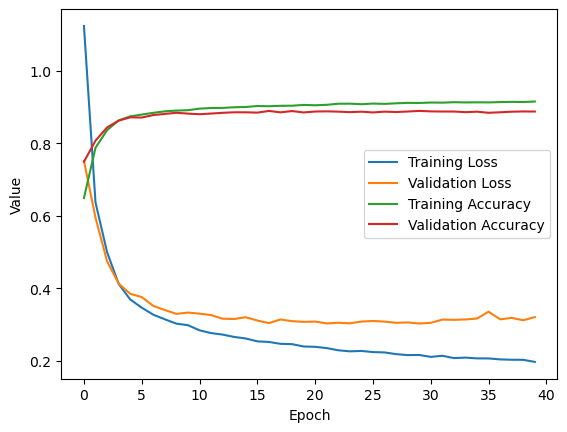

In [63]:
from keras.callbacks import EarlyStopping


# Define early stopping callback to monitor validation loss and stop if it doesn't improve for 5 epochs
early_stop = EarlyStopping(monitor='val_loss', patience=10)

# Train the model with 20 epochs and batch size of 32, using the early stopping callback
history = model.fit(x_train, y_train, epochs=200, batch_size=128, validation_data=(x_test, y_test), callbacks=[early_stop])

# Plot the training history for loss and accuracy
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.show()

# Evaluate the trained model 

In [64]:
# Import the required libraries
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score

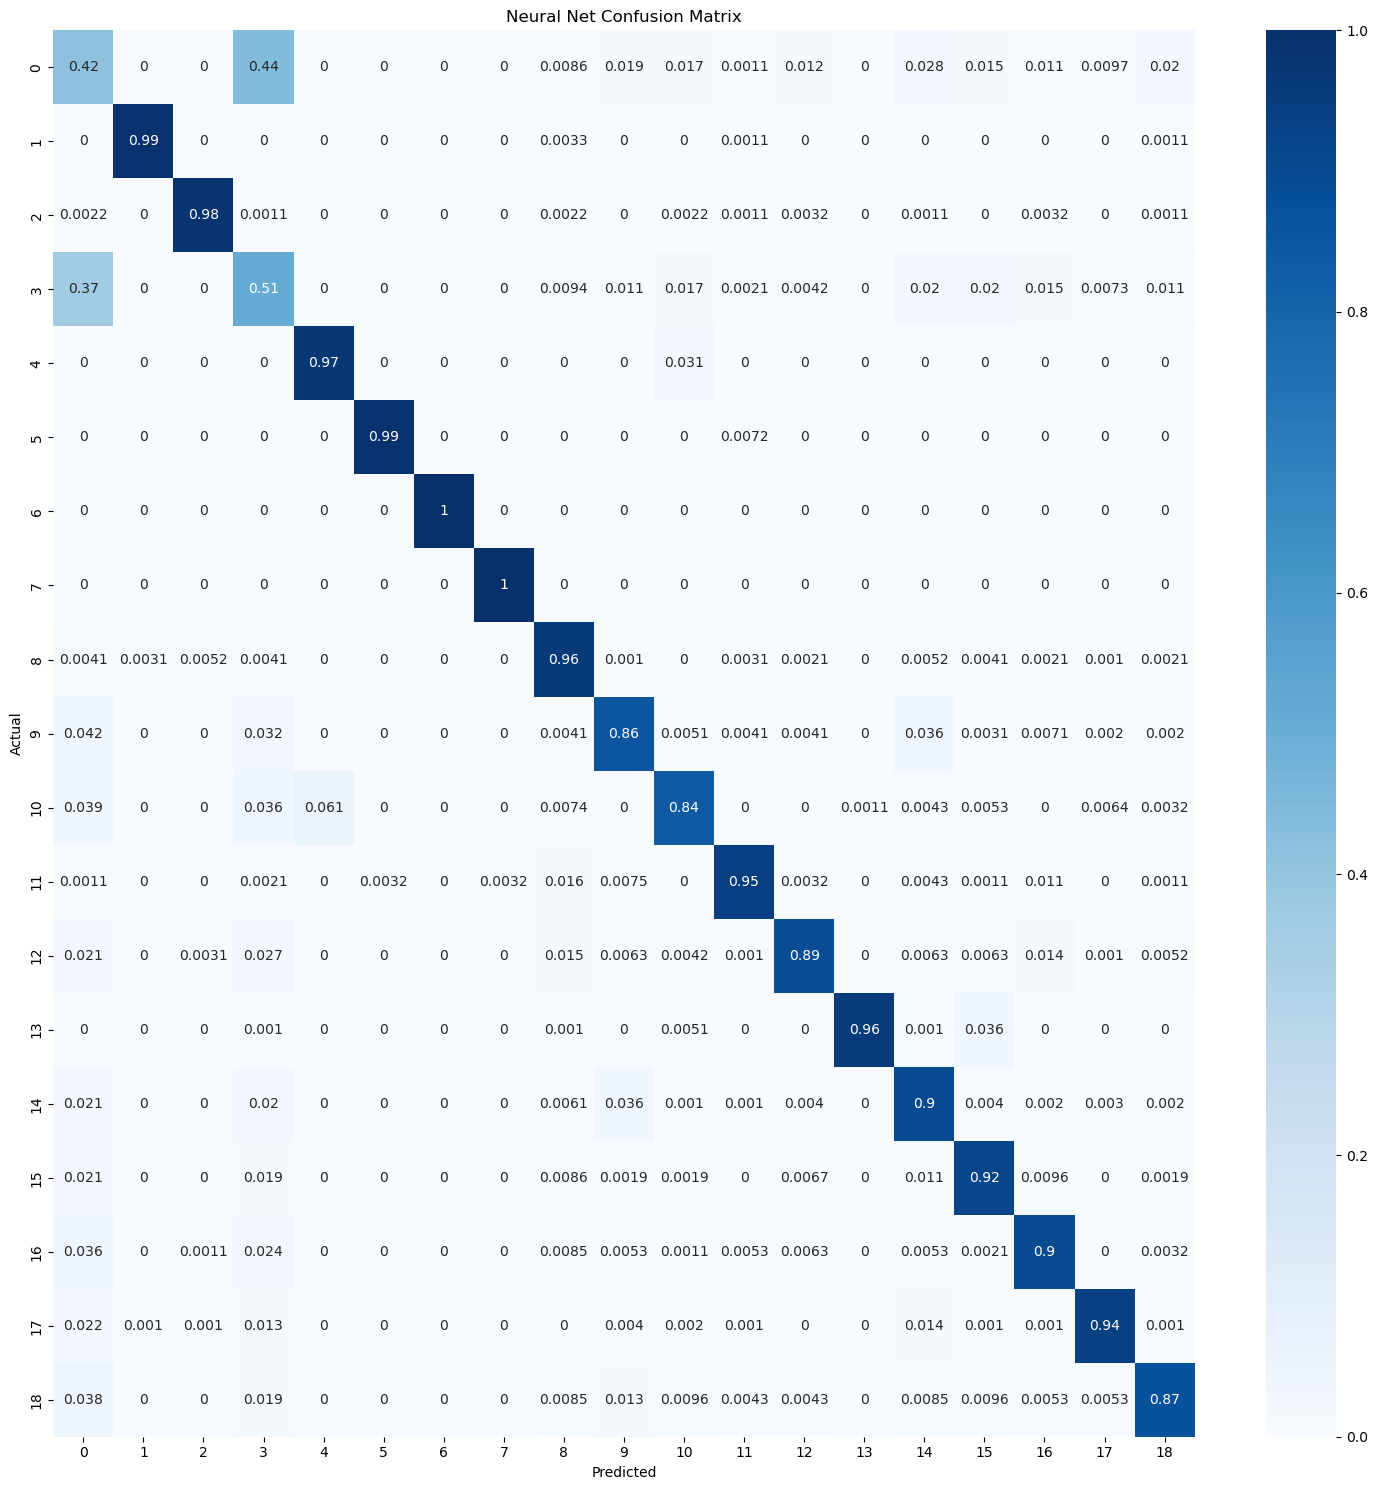

Neural Net accuracy_score: 0.8875


In [65]:


# Create a function to plot the confusion matrix
def plot_confusion_matrix(y_true, y_pred, title):
    f, ax = plt.subplots(figsize=(15, 15))
    cm = confusion_matrix(y_true, y_pred,normalize='true')
    sns.heatmap(cm, annot=True, cmap='Blues',ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_ylim(len(cm), 0)
    plt.tight_layout()
    plt.show()

y_pred = enc.inverse_transform(model.predict(x_test, verbose=0))
y_true = enc.inverse_transform(y_test)
    
# Plot the confusion matrix and print the f1 score for each algorithm
plot_confusion_matrix(y_true, y_pred, 'Neural Net Confusion Matrix')
print("Neural Net accuracy_score:", accuracy_score(y_true, y_pred))

# Obtain SIngle Accuracy Score matrice

In [66]:
Accuracy=[]
for Fnum in [x for x in range(0,21) if x not in [3,9,15]]:

    temp_df = DF[ (DF['faultNumber']==Fnum) & (DF['sample']>20) & (DF['simulationRun']==np.random.randint(1,500))]
    X_faulty = sc.transform(temp_df.iloc[:,3:])
    y_true = temp_df['faultNumber']
    
    y_pred = enc.inverse_transform(model.predict(X_faulty, verbose=0))
    
    
    acc = accuracy_score(y_true, y_pred)
    print(f'The accuracy for Fault_num={Fnum} is {acc}')
    
    Accuracy.append(acc)
print("#"*20)
print(f'The overall accuracy is {np.mean(Accuracy)}')

The accuracy for Fault_num=0 is 0.36041666666666666
The accuracy for Fault_num=1 is 0.9916666666666667
The accuracy for Fault_num=2 is 0.9854166666666667
The accuracy for Fault_num=4 is 0.9458333333333333
The accuracy for Fault_num=5 is 0.9708333333333333
The accuracy for Fault_num=6 is 1.0
The accuracy for Fault_num=7 is 1.0
The accuracy for Fault_num=8 is 0.85625
The accuracy for Fault_num=10 is 0.8395833333333333
The accuracy for Fault_num=11 is 0.8333333333333334
The accuracy for Fault_num=12 is 0.9583333333333334
The accuracy for Fault_num=13 is 0.8729166666666667
The accuracy for Fault_num=14 is 0.96875
The accuracy for Fault_num=16 is 0.8520833333333333
The accuracy for Fault_num=17 is 0.8895833333333333
The accuracy for Fault_num=18 is 0.4125
The accuracy for Fault_num=19 is 0.9291666666666667
The accuracy for Fault_num=20 is 0.8145833333333333
####################
The overall accuracy is 0.8600694444444446


# t-sne Visualization

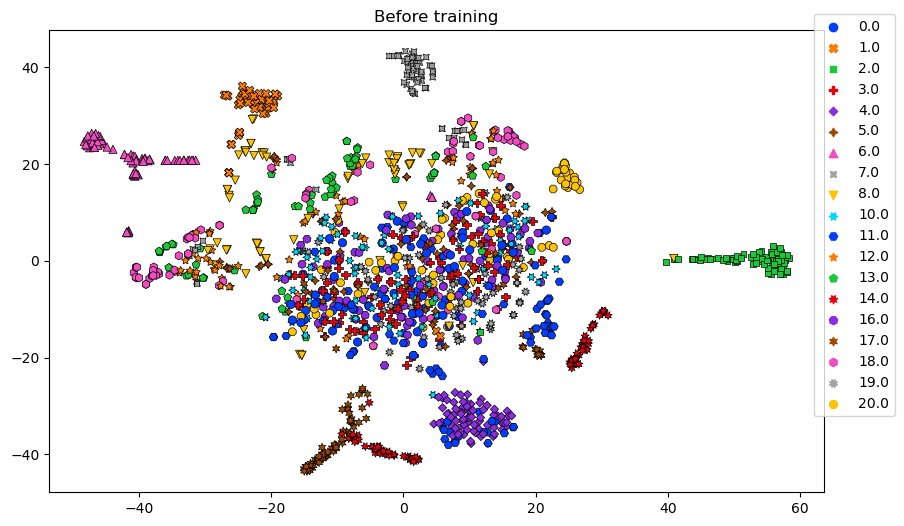

In [67]:
from sklearn.manifold import TSNE
x_embedded = TSNE(n_components=2, learning_rate='auto',init='random').fit_transform(x_train[::50,:])
y_label = enc.inverse_transform(y_train[::50,:]).reshape(-1)

# Create a scatter plot of the embedded data, colored by the true labels
f, ax = plt.subplots(figsize=(10,6))
sns.scatterplot(x=x_embedded[:,0],y=x_embedded[:,1],hue=y_label,style=y_label,palette="bright",edgecolor='black')
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.title('Before training')
plt.show()

# After Training

In [68]:
from tensorflow.keras import Model

intermediate_model = Model(inputs=model.input,outputs=model.layers[-2].output)
intermediate_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 52)]              0         
                                                                 
 dense_3 (Dense)             (None, 100)               5300      
                                                                 
 dense_4 (Dense)             (None, 100)               10100     
                                                                 
Total params: 15,400
Trainable params: 15,400
Non-trainable params: 0
_________________________________________________________________


46/46 [==============================] - 0s 2ms/step


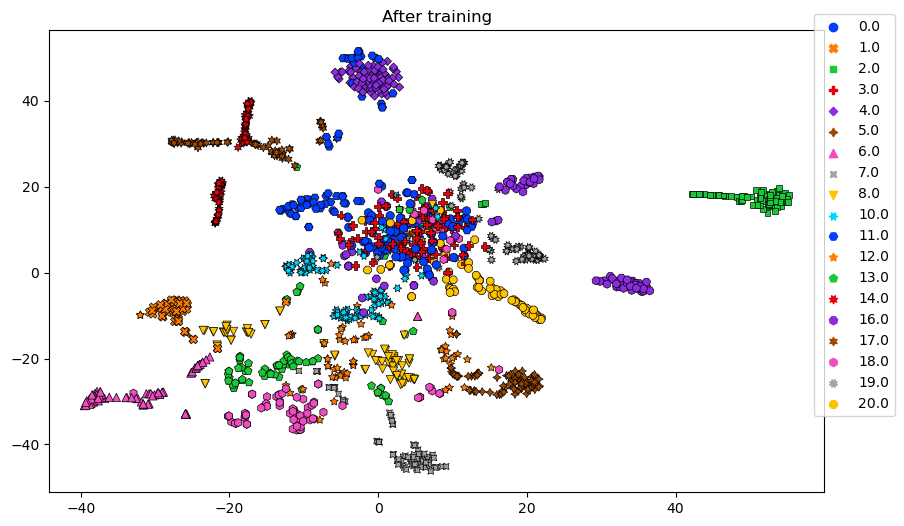

In [69]:
x_inter = intermediate_model.predict(x_train[::50,:])

x_embedded = TSNE(n_components=2, learning_rate='auto',init='random').fit_transform(x_inter)
y_label = enc.inverse_transform(y_train[::50,:]).reshape(-1)

# Create a scatter plot of the embedded data, colored by the true labels
f, ax = plt.subplots(figsize=(10,6))
sns.scatterplot(x=x_embedded[:,0],y=x_embedded[:,1],hue=y_label,style=y_label,palette="bright",edgecolor='black')
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.title('After training')
plt.show()

# Explanation using LIME

In [70]:
import lime
import lime.lime_tabular

In [71]:
#Create an Instance of LIME Tabular
lime_explainer = lime.lime_tabular.LimeTabularExplainer(x_train, feature_names=reduced_data.columns[3:], class_names=enc.categories_[0], discretize_continuous=True)

In [80]:
idx=34
y_pred = model.predict(np.expand_dims(x_test[idx], axis=0))
y_pred = enc.inverse_transform(y_pred)[0][0]
print(f"Predicted fault is {y_pred}")
exp = lime_explainer.explain_instance(x_test[idx], model.predict, num_features=10, top_labels=1)
exp.show_in_notebook(show_table=True, show_all=False)

1/1 [==============================] - 0s 67ms/step
Predicted fault is 7.0
157/157 [==============================] - 1s 6ms/step


# Explain using SHAP

In [73]:
import shap
shap.initjs()

In [74]:
# Convert the data into a dataframe with column names for easy plotting
X_test = pd.DataFrame(data=x_test,columns=reduced_data.columns[3:])

In [81]:
# Instantiate the SHAP Kernel
explainer = shap.KernelExplainer(model.predict, shap.sample(x_train[::50], 100))

# Provide the sample you need explanation for
shap_values = explainer.shap_values(X_test.iloc[idx])
# Actual predicted class
y_pred=int(enc.inverse_transform(y_test[idx].reshape(1,-1))[0][0])

6725/6725 [==============================] - 51s 8ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

In [82]:
display(shap.force_plot(explainer.expected_value[y_pred], shap_values[y_pred],X_test.iloc[idx_sample] ))

In [77]:
shap_values = explainer.shap_values(X_test.iloc[idx])
display(shap.force_plot(explainer.expected_value[y_pred], shap_values[y_pred],X_test.iloc[idx_sample] ))

6725/6725 [==============================] - 12s 2ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

# Visualize The effect of features

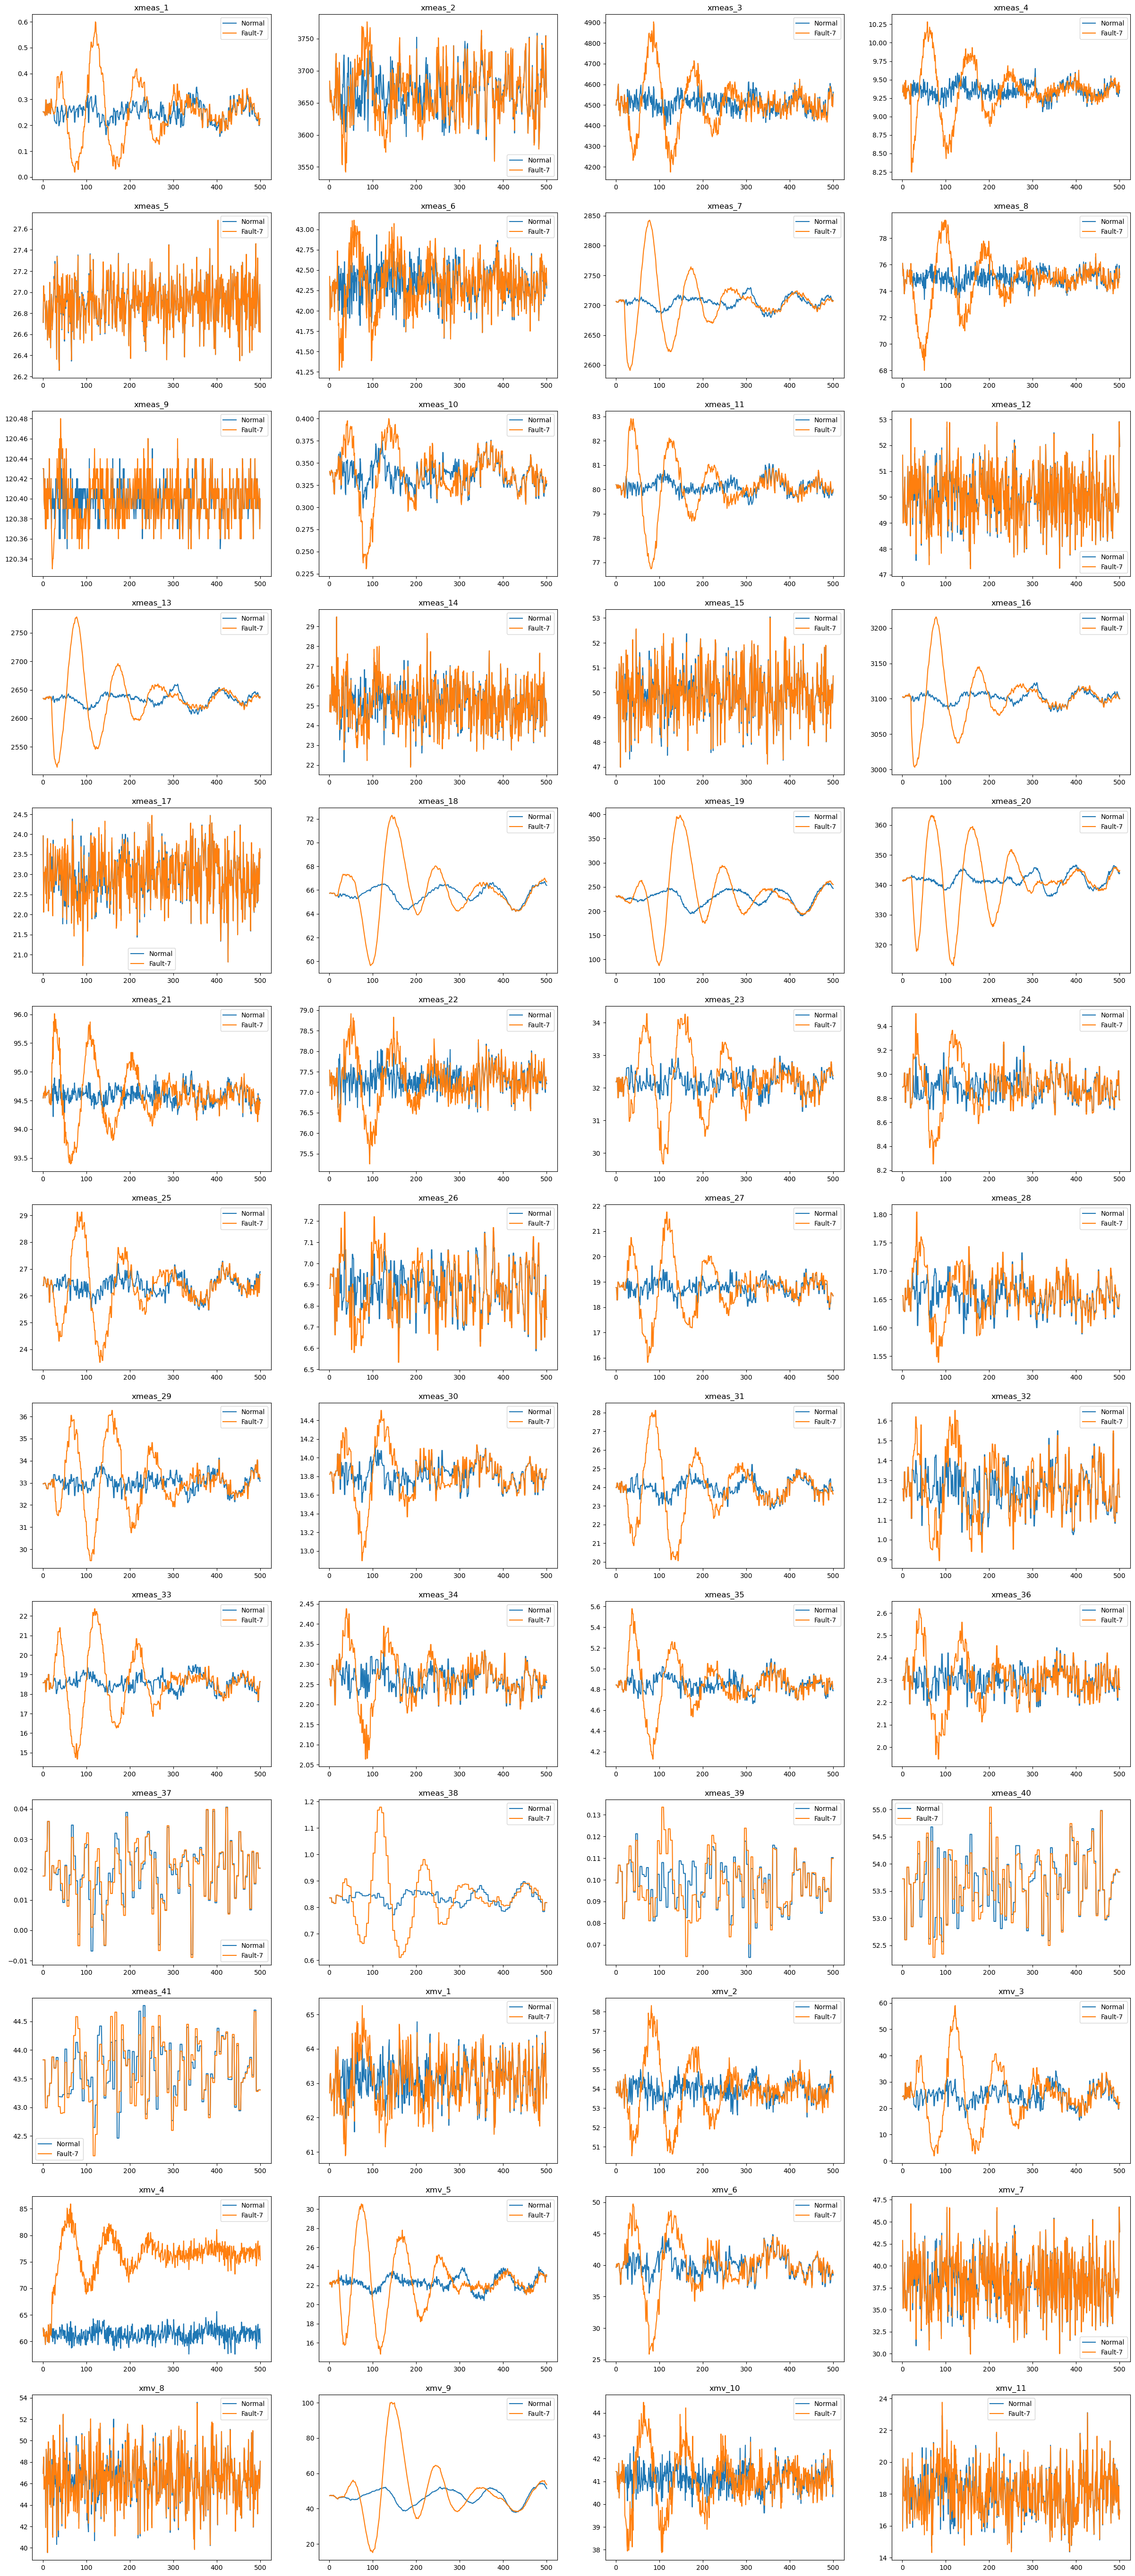

In [83]:

temp_df1 = DF[ (DF['faultNumber']==0) & (DF['simulationRun']==2)]
temp_df2 = DF[ (DF['faultNumber']==y_pred) & (DF['simulationRun']==2)]

fig, ax = plt.subplots(13,4,figsize=(30,70))

for i,col in enumerate(temp_df1.columns[3:]):  #select all the feature columns to plot
    ax.ravel()[i].plot(temp_df1['sample'],temp_df1[col],label='Normal')
    ax.ravel()[i].plot(temp_df2['sample'],temp_df2[col],label=f'Fault-{y_pred}')
    ax.ravel()[i].set_title(col)
    ax.ravel()[i].legend()